# Recommendation System Using RBM

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

The data contains 3 files: 
- movies.dat (contains: id | moviename | type
- users.dat (contains: id | gender | age-range | occupation | zipcode)
- ratings.dat(contains: userID | movieID | rating | timestamp)

In [4]:
movies_df = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, engine='python')
print("MOVIES")
movies_df.head()

MOVIES


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, engine='python')
print("RATINGS")
ratings_df.head()

RATINGS


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Rename the columns

In [7]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Formatting the data

In [9]:
len(movies_df)

3883

In [13]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalize the data

In [15]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
x_train = norm_user_rating_df.values
x_train[0:10]

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 1. , 0. , ..., 0. , 0. , 0. ]])

## Model

The RBM has 2 layers, visible and hidden. The input will be fed through the visible layer. Each neuron in this model will process a normalized rating value varying from 0 to 1, where 0 means the user has not watched the movie and in the other hand we can say the more the value it is (closer to 1) the more the user liked the movie.

Model Parameters

In [16]:
len(user_rating_df.columns)

3706

In [18]:
hidden_units = 20
visible_units = len(user_rating_df.columns)
v_bias = tf.placeholder("float", [visible_units]) #Number of unique movies
h_bias = tf.placeholder("float", [hidden_units])
W = tf.placeholder("float", [visible_units, hidden_units])

Creating the layers

In [19]:
# Input
v0 = tf.placeholder("float", [None, visible_units])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + h_bias)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
# Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + v_bias)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + h_bias)

In [20]:
# learning rate
alpha = 0.1
# gradients 
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
# Contrasive divergence 
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
# methods to update the weights and biases
update_w = W + alpha * CD
update_v_bias = v_bias + alpha * tf.reduce_mean(v0 - v1, 0)
update_h_bias = h_bias + alpha * tf.reduce_mean(h0 - h1, 0)

Error function

In [23]:
error = v0 - v1 # INPUT - RECONSTRUCTION
error_sum = tf.reduce_mean(error * error)

In [21]:
cur_w = np.zeros([visible_units, hidden_units], np.float32)

cur_v_bias = np.zeros([visible_units], np.float32)
cur_h_bias = np.zeros([hidden_units], np.float32)

prev_w = np.zeros([visible_units, hidden_units], np.float32)

prev_v_bias = np.zeros([visible_units], np.float32)
prev_h_bias = np.zeros([hidden_units], np.float32)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.102216356
0.08022366
0.075009145
0.0680984
0.064094
0.056521934
0.051610284
0.04944747
0.048120886
0.04745399
0.04668593
0.046294674
0.046004124
0.045649923
0.045315064
0.045015845
0.044793177
0.044622183
0.04441546
0.044320397


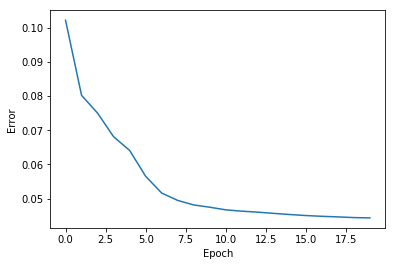

In [24]:
epochs = 20
batchsize = 100
errors = []

for i in range(epochs):
    for start, end in zip(range(0, len(x_train), batchsize), range(batchsize, len(x_train), batchsize)):
        batch = x_train[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prev_w, v_bias:prev_v_bias, h_bias: prev_h_bias})
        cur_v_bias = sess.run(update_v_bias, feed_dict={v0: batch, W: prev_w, v_bias:prev_v_bias, h_bias: prev_h_bias})
        cur_h_bias = sess.run(update_h_bias, feed_dict={v0: batch, W: prev_w, v_bias:prev_v_bias, h_bias: prev_h_bias})
        prev_w = cur_w
        prev_v_bias = cur_v_bias
        prev_h_bias = cur_h_bias
    errors.append(sess.run(error_sum, feed_dict={v0:x_train, W:cur_w, v_bias:cur_v_bias,h_bias:cur_h_bias}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

## Inference

In [25]:
our_user_id = 777

In [27]:
# Select from data
input_user = x_train[our_user_id - 1].reshape(1,-1)
input_user[0:10]

array([[0.6, 0.6, 0. , ..., 0. , 0. , 0. ]])

In [29]:
# feeding in our user and reconstruct
hh0 = tf.nn.sigmoid(tf.matmul(v0,W) + h_bias)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + v_bias)
feed = sess.run(hh0, feed_dict={v0: input_user, W: prev_w, h_bias: prev_h_bias})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prev_w, v_bias: prev_v_bias})
print(rec)

[[0.5294142  0.30786097 0.15290457 ... 0.01791448 0.01278012 0.0542346 ]]


Now we can use that data to recommend 20 movies by sorting in descending order

In [34]:
scored_movies_df_user = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
# print(scored_movies_df_user)
scored_movies_df_user = scored_movies_df_user.assign(RecommendationScore=rec[0])
# print(scored_movies_df_user)
scored_movies_df_user.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.582955
2647,2716,Ghostbusters (1984),Comedy|Horror,0.564776
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.556828
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.544578
352,356,Forrest Gump (1994),Comedy|Romance|War,0.541351
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,0.540237
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.531078
770,780,Independence Day (ID4) (1996),Action|Sci-Fi|War,0.530305
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,0.529940
0,1,Toy Story (1995),Animation|Children's|Comedy,0.529414


Now we will find the movies that our user has watched before

In [36]:
movies_df_user = ratings_df[ratings_df['UserID'] == our_user_id]
movies_df_user.head()

,UserID,MovieID,Rating,Timestamp
120188,777,2987,3,975522906
120189,777,719,2,975438923
120190,777,2050,2,975958037
120191,777,3791,3,975957569
120192,777,2052,2,975521245


Merge the watched movies and predicted scores

In [41]:
merge_df_user = scored_movies_df_user.merge(movies_df_user, on='MovieID', how='outer')
merge_df_user.head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,0.529414,777.0,3.0,975438109.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.307861,777.0,3.0,975440088.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.152905,NaN,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama,0.054757,NaN,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,0.135541,777.0,2.0,975438923.0
5,6,Heat (1995),Action|Crime|Thriller,0.280715,NaN,NaN,NaN
6,7,Sabrina (1995),Comedy|Romance,0.161785,777.0,2.0,975438437.0
7,8,Tom and Huck (1995),Adventure|Children's,0.023160,NaN,NaN,NaN
8,9,Sudden Death (1995),Action,0.035204,NaN,NaN,NaN
9,10,GoldenEye (1995),Action|Adventure|Thriller,0.342025,NaN,NaN,NaN


In [45]:
merge_df_user.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.582955,777.0,4.0,975436861.0
2511,2716,Ghostbusters (1984),Comedy|Horror,0.564776,777.0,3.0,975522694.0
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.556828,777.0,4.0,975436906.0
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.544578,777.0,4.0,975436861.0
346,356,Forrest Gump (1994),Comedy|Romance|War,0.541351,777.0,5.0,975436531.0
1178,1270,Back to the Future (1985),Comedy|Sci-Fi,0.540237,777.0,3.0,975436861.0
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.531078,777.0,5.0,975436861.0
737,780,Independence Day (ID4) (1996),Action|Sci-Fi|War,0.530305,777.0,3.0,975437216.0
1108,1198,Raiders of the Lost Ark (1981),Action|Adventure,0.529940,777.0,4.0,975522541.0
0,1,Toy Story (1995),Animation|Children's|Comedy,0.529414,777.0,3.0,975438109.0
